In [10]:
import matplotlib.cbook as cbook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from imblearn.ensemble import EasyEnsembleClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from xgboost.sklearn import XGBClassifier

from ensemble import MakeEnsemble
from util import load_data, fdr

In [2]:
x_train, _, x_oot, y_train, _, y_oot = load_data('var_30.csv', test_size=0)
x_train = x_train.to_numpy()

In [3]:
def add_score(score, label, train_scores, test_scores):
    train_scores.append(score['train_score'])
    test_scores.append(score['test_score'])
    labels.append(label)
    print(np.mean(score['test_score']))

In [4]:
labels = []
train_scores = []
test_scores = []

In [5]:
# Logistic regression
lr = LogisticRegression(max_iter=1000, 
                        C=1, 
                        class_weight='balanced').fit(x_train, y_train)
score = cross_validate(lr, x_train, y_train, 
                       scoring=fdr, cv=10, return_train_score=True)
add_score(score, 'LR', train_scores, test_scores)

0.5285038382205967


In [6]:
# Decision tree
dt = DecisionTreeClassifier(ccp_alpha=1e-06, 
                            max_depth=20,
                            min_samples_leaf=64, 
                            class_weight=None,
                            criterion='gini')
score = cross_validate(dt, x_train, y_train, 
                       scoring=fdr, cv=10, n_jobs=8, return_train_score=True)
add_score(score, 'DT', train_scores, test_scores)

0.5461989920683863


In [7]:
# Random forest
rf = RandomForestClassifier(n_estimators=300,
                            max_depth=17, 
                            max_features=10,
                            ccp_alpha=1e-6, 
                            n_jobs=8).fit(x_train, y_train)
score = cross_validate(rf, x_train, y_train, 
                       scoring=fdr, cv=10, return_train_score=True)
add_score(score, 'RF', train_scores, test_scores)

0.5503829866733093


In [8]:
# Boosted tree
bt = XGBClassifier(n_estimators=200,
                   max_depth=5,
                   learning_rate=0.05,
                   subsample=0.5,
                   verbose=3, n_jobs=8).fit(x_train, y_train)
score = cross_validate(bt, x_train, y_train, 
                       scoring=fdr, cv=10, return_train_score=True)
add_score(score, 'BT', train_scores, test_scores)

0.5497727749104617


In [11]:
# Adaboost
ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3),
                         learning_rate=0.1,
                         n_estimators=50,
                         algorithm='SAMME.R')
score = cross_validate(ada, x_train, y_train, 
                       scoring=fdr, cv=10, n_jobs=5, verbose=0,
                       return_train_score=True)
add_score(score, 'ADA', train_scores, test_scores)

0.5491624872033998


In [12]:
# Random forest with random under sampling
rf = RandomForestClassifier(n_estimators=100,
                            max_depth=17, 
                            max_features=10,
                            ccp_alpha=1e-6, 
                            n_jobs=4)
ee = EasyEnsembleClassifier(n_estimators=50,
                            base_estimator=rf,
                            sampling_strategy='not minority',
                            n_jobs=2,
                            verbose=0).fit(x_train, y_train)
score = cross_validate(ee, x_train, y_train, 
                       scoring=fdr, cv=10, return_train_score=True)
add_score(score, 'RF_US', train_scores, test_scores)

0.5492496711615515


In [13]:
# Decision tree with Random undersample to 10% and then SMOTE
score = {'train_score': [], 'test_score': []}
for _ in range(10):
    x, x_test, y, y_test = train_test_split(x_train, y_train, test_size=0.1)
    dt = DecisionTreeClassifier(ccp_alpha=1e-06, max_depth=20, min_samples_leaf=64, class_weight=None, criterion='gini')
    me = MakeEnsemble(dt, [RandomUnderSampler(sampling_strategy=0.1), SMOTE()],
                      n_estimators=50, n_jobs=8, verbose=0)
    me.fit(x, y)
    score['train_score'].append(fdr(me, x, y))
    score['test_score'].append(fdr(me, x_test, y_test))

score['train_score'] = np.asarray(score['train_score'])
score['test_score'] = np.asarray(score['test_score'])
add_score(score, 'DT_SMOTE', train_scores, test_scores)

0.541961484730334


In [14]:
result = pd.DataFrame(test_scores, index=labels)
result['Mean'] = result.mean(numeric_only=True, axis=1)
result['Mean']

LR             0.528504
DT             0.546199
RF             0.550383
BT             0.549773
ADA            0.549162
RF_US          0.549250
DT_US_SMOTE    0.541961
Name: Mean, dtype: float64

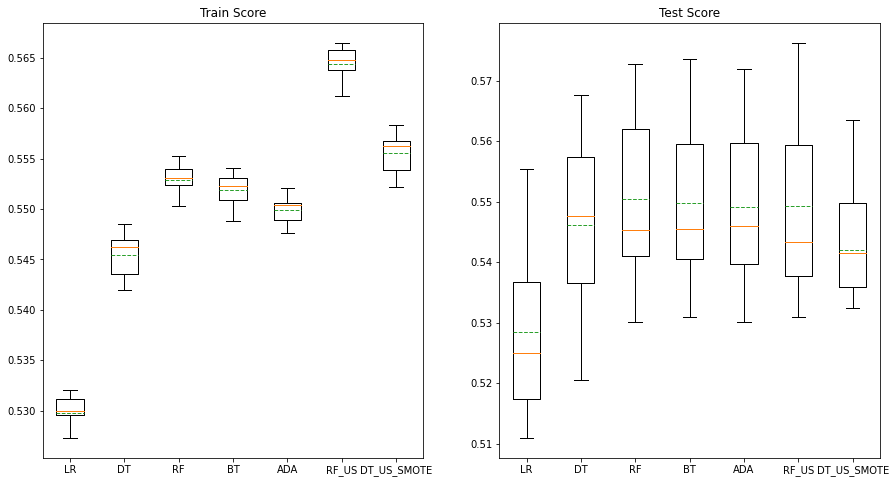

In [15]:
train_stats = cbook.boxplot_stats(train_scores, labels=labels)
test_stats = cbook.boxplot_stats(test_scores, labels=labels)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))
ax[0].bxp(train_stats, showfliers=False, meanline=True, showmeans=True)
ax[0].set_title('Train Score')
ax[1].bxp(test_stats, showfliers=False, meanline=True, showmeans=True)
ax[1].set_title('Test Score')
plt.show()

In [16]:
import pickle
load = {'labels': labels,
        'train_scores': train_scores,
        'test_scores': test_scores}
with open('model_results.dump', 'wb') as f:
    pickle.dump(load, f)